# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before but how do you want to get your own data into PyTorch?

One of the ways to do so is via: Custom datasets.

## Domain Libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries existing data loading functions and customizable data loading functions.

**Resources**
* Book Version of the course materials 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground Truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


## 0. Importing PyTorch an setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food. (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Downlaod pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi dataset")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path:str):
  """
  Walks through dir_path returning its contents

  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdirs in dir_path
      number of images (files) in each subdir
      name of each subdir
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an Image

Let's write some code to
1. Get all image paths
2. Pick a random image path using Python's rando.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the images with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/667309.jpg
Image Class: pizza
Image size: (512, 384)
Image mode: RGB
Image format: JPEG
Image height: 384
Image width: 512



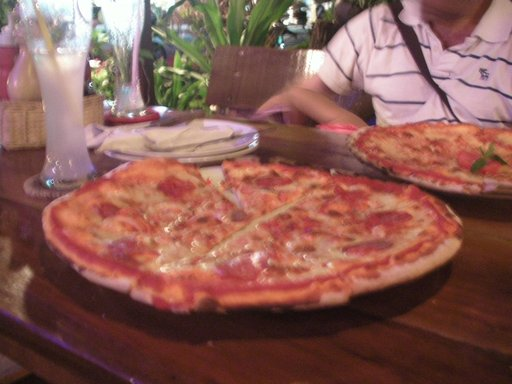

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"Random image path: {random_image_path}")

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(f"Image Class: {image_class}")

# 4. Open image
img = Image.open(random_image_path)

# 5. Print iage metadata
print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")
print(f"Image format: {img.format}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}\n")

# 6. Show image
img

In [8]:
image_path

PosixPath('data/pizza_steak_sushi')

(-0.5, 511.5, 383.5, -0.5)

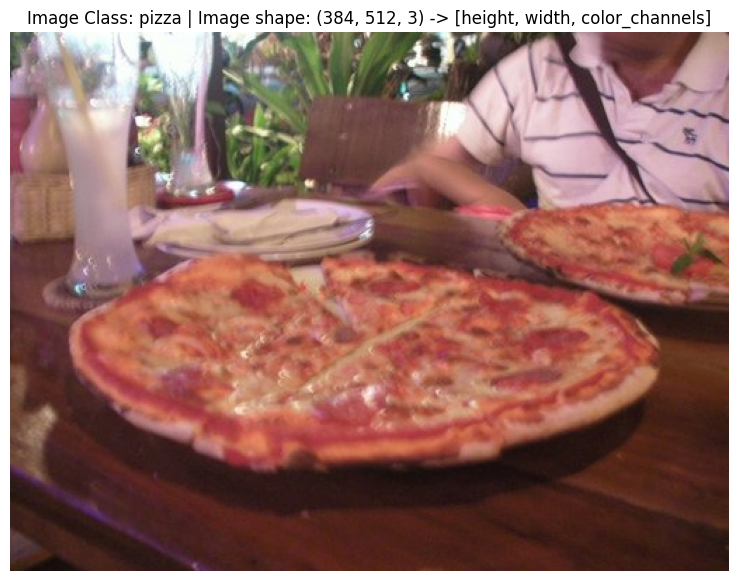

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

array([[[ 91,  98,  80],
        [ 85,  92,  74],
        [ 92, 101,  80],
        ...,
        [143, 110, 105],
        [111,  77,  75],
        [ 83,  49,  47]],

       [[ 84,  91,  75],
        [ 82,  89,  73],
        [ 93, 102,  83],
        ...,
        [159, 126, 121],
        [134, 100,  98],
        [110,  76,  74]],

       [[ 79,  85,  73],
        [ 81,  87,  75],
        [ 92, 100,  85],
        ...,
        [173, 140, 133],
        [158, 125, 120],
        [142, 109, 104]],

       ...,

       [[ 60,  36,  26],
        [ 59,  35,  23],
        [ 58,  36,  23],
        ...,
        [ 46,  23,  17],
        [ 46,  22,  18],
        [ 45,  21,  19]],

       [[ 57,  34,  26],
        [ 56,  34,  23],
        [ 56,  34,  23],
        ...,
        [ 49,  24,  19],
        [ 49,  24,  20],
        [ 49,  24,  20]],

       [[ 49,  26,  18],
        [ 48,  25,  17],
        [ 50,  28,  17],
        ...,
        [ 50,  25,  20],
        [ 50,  25,  21],
        [ 50,  25,  21]]], dtype=uint8)
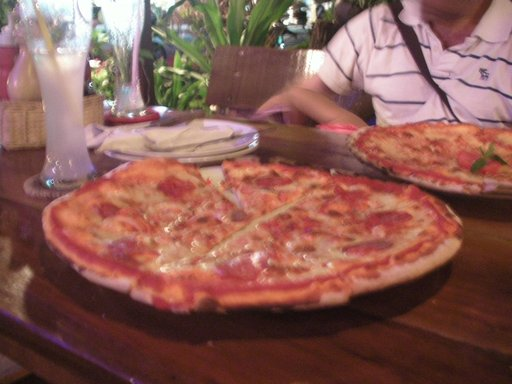

In [10]:
img_as_array

## 3. Transforming the data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).config.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these dataset and dataloader

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you to get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/0.9/transforms.html


In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to (64x64)
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

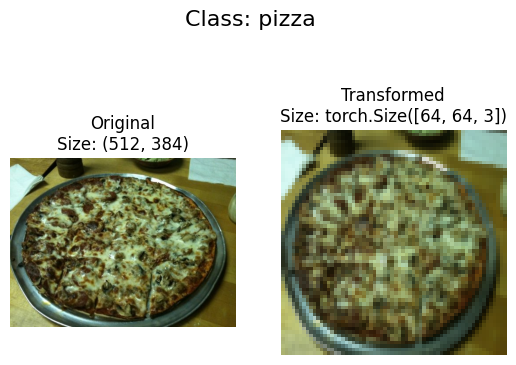

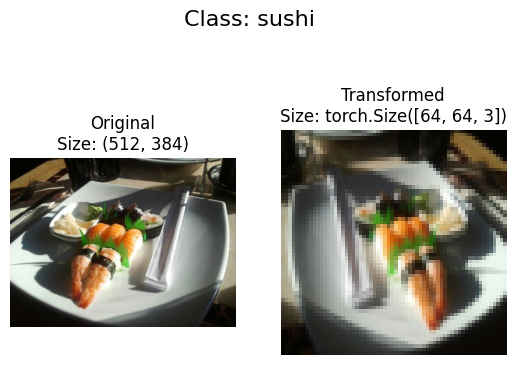

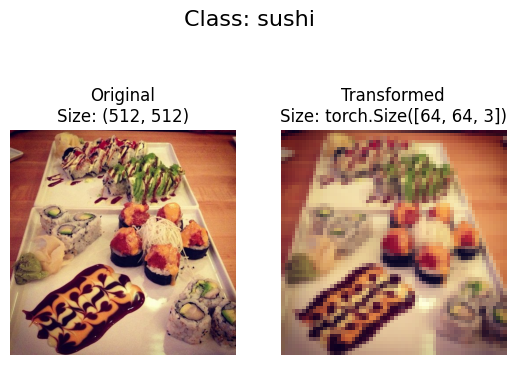

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then
  plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Change shape for matplotlib from (CxHxW) -> (HxWxC)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform)

In [14]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3109486.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/765799.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2687575.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885796.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2382016.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1649276.jpg')]

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` -
https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [15]:
# Use Imagefolder to create datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transform for image
                                  target_transform=None) # Transform for label
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengthhs of our dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}\n")
print(f"Image shape: {img.shape}\n")
print(f"Image label: {label}\n")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]

Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]



(-0.5, 63.5, 63.5, -0.5)

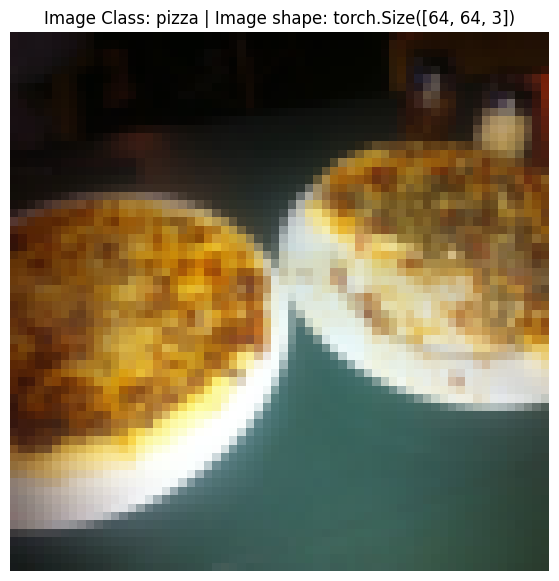

In [20]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]\n")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]\n")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(f"Image Class: {class_names[label]} | Image shape: {img_permute.shape}")
plt.axis(False)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize batch_size so our model ca see batch_sice images at a time.

In [21]:
# Turn train and test datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e8227c1b010>,
 <torch.utils.data.dataloader.DataLoader at 0x7e8227bac590>)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label: torch.Size([1])


## Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything
* Using a custom `Dataset` often results in us writing more code.

All custom datasets in PyTorch subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset



In [25]:
import os
import pathlib
import matplotlib.pyplot as plt

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

 ### 5.1 Creating a helper function to get class names

 We want a function to:
 1. Get the class names using the `os.scandir()` to traverse a target directory(ideally the directory already in the standard image classification format).
 2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
 3. Turn the class names into a dict and a list and return them.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get class names as a list
class_names = sorted([entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir()])
class_names

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the clas folder names in a target directory.
  """
  # 1. Get the clas names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in directory: {directory}... please check file structure. ")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom Dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transfrom we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [30]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform = None):
    # 3. Create class attributes

    # Get all of the iage paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transforms
    self.transform = transform

    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Loads and returns image at index
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len__() method
  def __len__(self):
    return len(self.paths)

  # 6. Overwrite the __getitem__() method
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data (X,y)
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return untransformed image and label

In [31]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform=test_transforms)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(train_data_custom.class_to_idx==train_data.class_to_idx)

True
True


### 5.3 Create a functio to display random images

1. Take in `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproduceibility
4. Get a list of random sample indices from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images lines up with matplotlib (HWC)

In [38]:
# 1. Creat a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None
                          ):
  # 2. adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be larger than 10, setting to 10 max")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indices
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indices and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    # plt.title(f"Class: {classes[targ_label]} | Sample {i+1} of {n}")
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

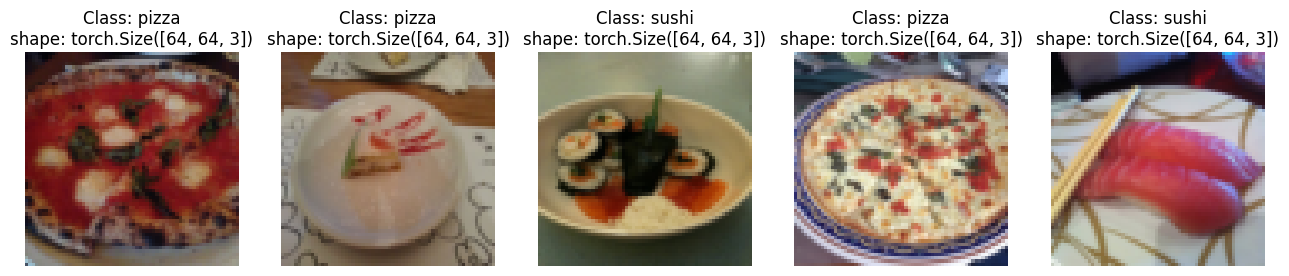

In [39]:
display_random_images(train_data, train_data.classes, n=5)

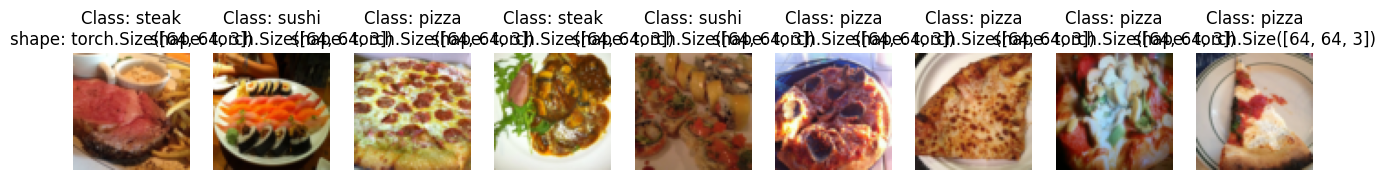

In [40]:
display_random_images(train_data_custom, train_data_custom.classes, n=9, seed=None)

### 5.4 Turn custom loaded images into a dataloader

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e8227137390>,
 <torch.utils.data.dataloader.DataLoader at 0x7e822723aa10>)

In [42]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [43]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [44]:
img_custom.shape, label_custom

(torch.Size([32, 3, 64, 64]),
 tensor([0, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 2, 0, 1, 0,
         0, 2, 1, 1, 2, 0, 0, 2]))

## 6. Other Froms of Transforms (Data Augmentation)

Data Augmentation is the proces of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformation to the training images.

More on PyTorch Image Augmentation - https://pytorch.org/vision/main/transforms.html

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one partcular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [45]:
# Lets look at trivial Augment

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [46]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3109486.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/765799.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2687575.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885796.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2382016.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1649276.jpg')]

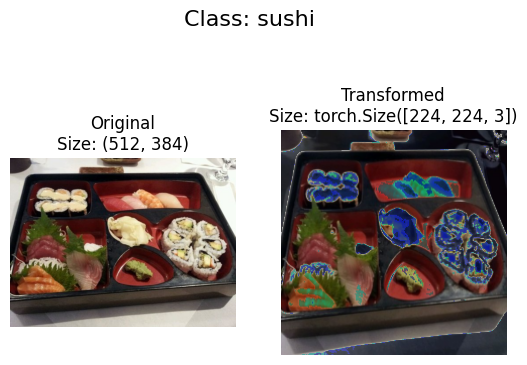

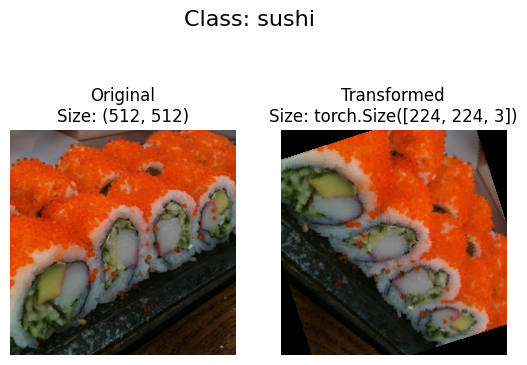

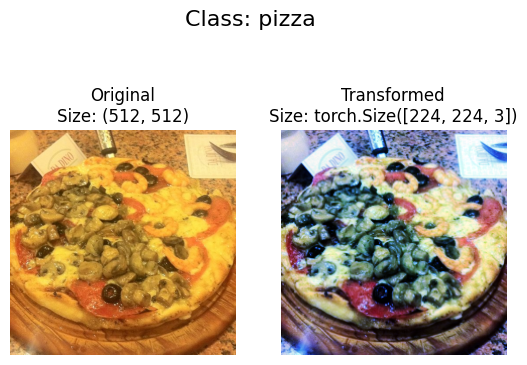

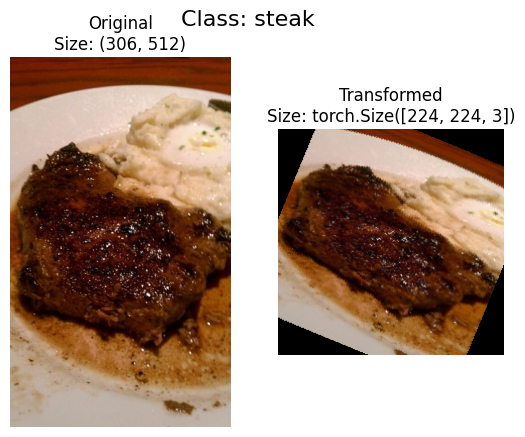

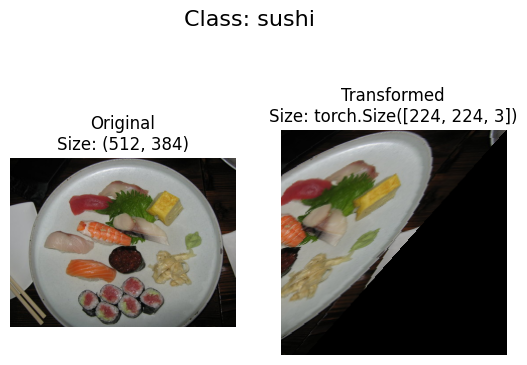

In [47]:
# Plot random transformed_images
plot_transformed_images(image_paths=image_path_list,
                        transform = train_transform,
                        n = 5)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate the TinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [48]:
# Creating simple transform
from torchvision import datasets, transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# 2. Load Datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform,
                                 target_transform=None)

# 3. Turn Dataset into Dataloader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

### 7.2 Create TinyVGG Model Class

In [49]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer website
  """
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

In [50]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                   hidden_units=10,
                   output_shape=len(train_data.classes))


### 7.3 Try a forward pass on a single image (to test the model)

In [51]:
# model_0.eval()
# with torch.inference_mode():
#   y_logits = model_0(img.squeeze(dim=1))

# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [52]:
# Try a forward pass
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(image_batch)
  y_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_probs[:5]

(tensor([[ 0.0208, -0.0020,  0.0095],
         [ 0.0184,  0.0025,  0.0067],
         [ 0.0177,  0.0010,  0.0095],
         [ 0.0244, -0.0033,  0.0096],
         [ 0.0199,  0.0007,  0.0108]]),
 tensor([[0.3371, 0.3295, 0.3333],
         [0.3364, 0.3311, 0.3325],
         [0.3361, 0.3305, 0.3334],
         [0.3381, 0.3288, 0.3331],
         [0.3365, 0.3301, 0.3334]]))

In [53]:
!pip install torchinfo

In [54]:
from torchinfo import summary
summary(model_0, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 7.5 Create a train and test step loop functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [55]:
# Create an Accuracy Function
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [74]:
# Import for typehint
from collections.abc import Callable
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device: torch.device,
               accuracy_fn: Callable) -> Tuple[float, float]:
  """
  Performs a Training Step:
  1. Do a forward pass
  2. Calculate the loss
  3. Optimizer Zero Grad
  4. Loss Backward
  """
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_logits = model(X)
    y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # Calculate the loss
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y, y_pred_class)

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer Step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: Callable,
              device: torch.device) -> Tuple[float, float]:
  model.to(device)
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_pred_class = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      test_acc += accuracy_fn(y, test_pred_class)
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [75]:
# Initialize a loss function and an optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.05)

device = "cuda" if torch.cuda.is_available() else "cpu"

### 7.6 Creating a `train()` function to combine `train_step()` ans `test_step()`

In [76]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       accuracy_fn=accuracy_fn)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    accuracy_fn=accuracy_fn)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [77]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 30.4688 | Test loss: 1.0983 | Test acc: 30.1136
Epoch: 1 | Train loss: 1.0998 | Train acc: 32.8125 | Test loss: 1.0697 | Test acc: 54.1667
Epoch: 2 | Train loss: 1.0869 | Train acc: 48.8281 | Test loss: 1.0808 | Test acc: 49.2424
Epoch: 3 | Train loss: 1.0844 | Train acc: 40.2344 | Test loss: 1.0607 | Test acc: 58.3333
Epoch: 4 | Train loss: 1.0663 | Train acc: 41.7969 | Test loss: 1.0655 | Test acc: 56.4394
Total training time: 5.528 seconds


In [78]:
model_0_results

{'train_loss': [1.1063192635774612,
  1.0998077541589737,
  1.0868802666664124,
  1.0844174474477768,
  1.0662949532270432],
 'train_acc': [30.46875, 32.8125, 48.828125, 40.234375, 41.796875],
 'test_loss': [1.098322828610738,
  1.0697026252746582,
  1.0807757377624512,
  1.0607309738794963,
  1.0655232667922974],
 'test_acc': [30.113636363636363,
  54.166666666666664,
  49.24242424242425,
  58.333333333333336,
  56.43939393939394]}

### 7.8 Plot the loss curves of Model 0
A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [80]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

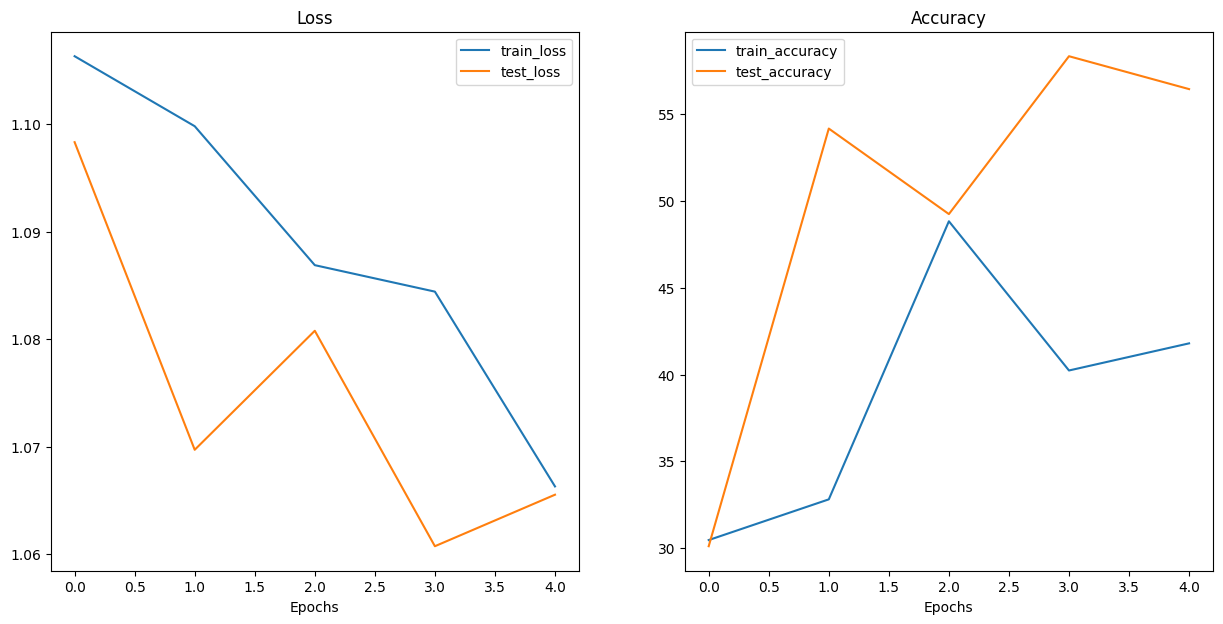

In [81]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation
Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [82]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's with data augmentation

In [83]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [84]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data.

In [85]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [86]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 25.0000 | Test loss: 1.1019 | Test acc: 26.0417
Epoch: 1 | Train loss: 1.0807 | Train acc: 42.5781 | Test loss: 1.1261 | Test acc: 26.0417
Epoch: 2 | Train loss: 1.0712 | Train acc: 42.5781 | Test loss: 1.1592 | Test acc: 26.0417
Epoch: 3 | Train loss: 1.1254 | Train acc: 30.4688 | Test loss: 1.1581 | Test acc: 26.0417
Epoch: 4 | Train loss: 1.0858 | Train acc: 42.5781 | Test loss: 1.1551 | Test acc: 33.3333
Total training time for model_1: 5.398 seconds


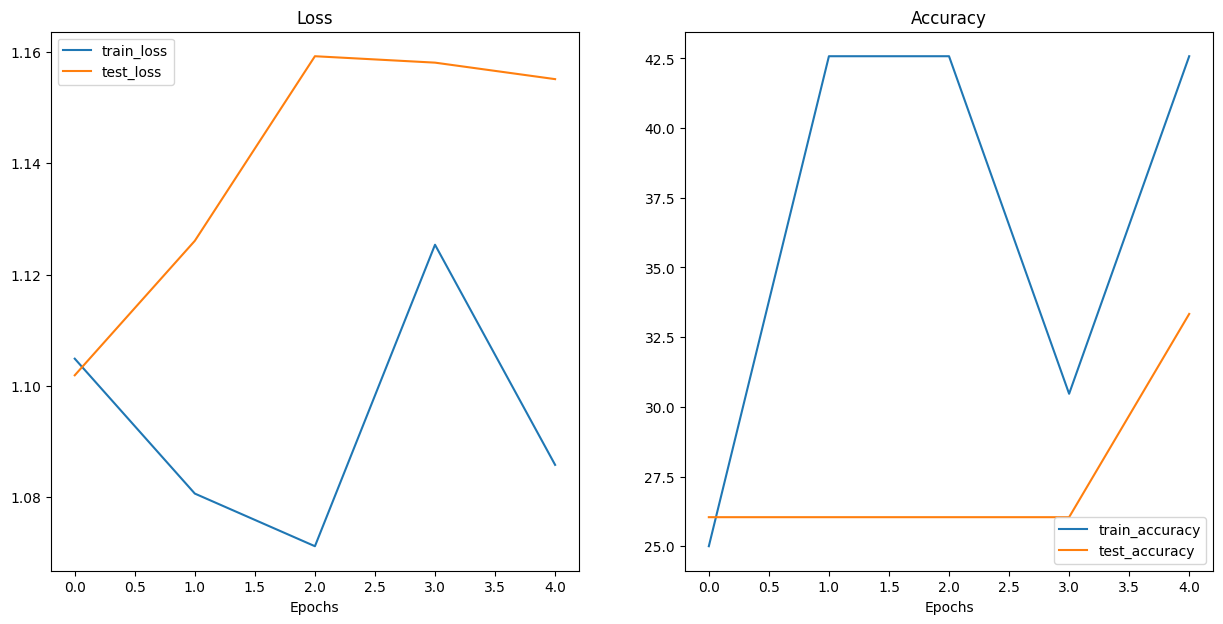

In [87]:
plot_loss_curves(model_1_results)

## 0. Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

* Hard coding (what we're doing)
* PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
* Weights & Biases - https://wandb.ai/site/experiment-tracking
* MLFlow - https://mlflow.org/

In [88]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss   test_acc
0    1.106319  30.468750   1.098323  30.113636
1    1.099808  32.812500   1.069703  54.166667
2    1.086880  48.828125   1.080776  49.242424
3    1.084417  40.234375   1.060731  58.333333
4    1.066295  41.796875   1.065523  56.439394

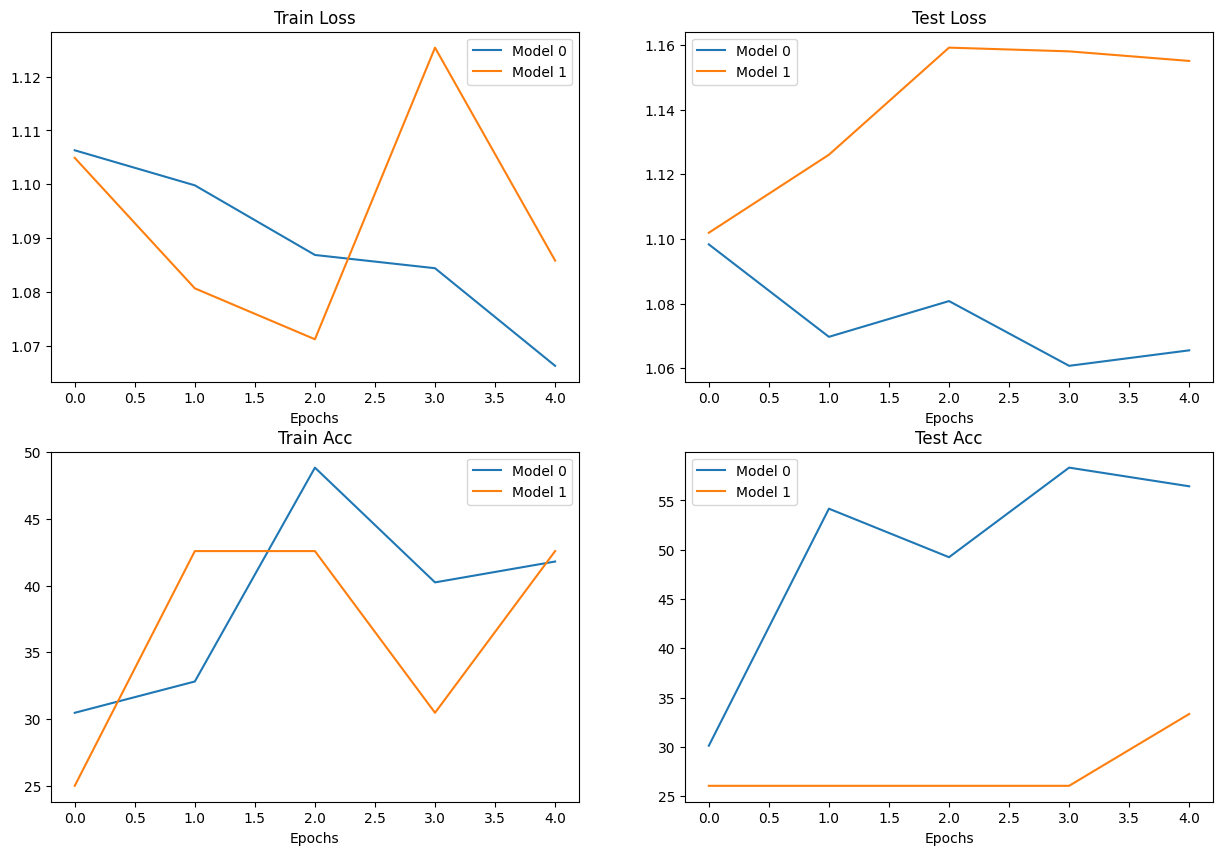

In [89]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();